# Remote computing on Quandela Cloud

Here we aim at showing how to connect to Quandela Cloud services to perform computation with real QPU and simulators remotely. We are going to use a simple two modes circuit here.

In [1]:
import time
import numpy as np
from tqdm.notebook import tqdm

import perceval as pcvl
from perceval.algorithm import Sampler

First, define your objects through Perceval as usual.

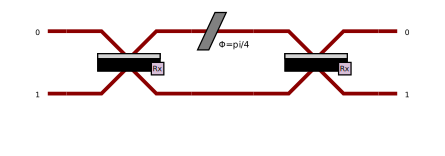

In [2]:
input_state = pcvl.BasicState([1, 1])

c = pcvl.Circuit(2)
c.add(0, pcvl.BS())
c.add(0, pcvl.PS(phi = np.pi/4))
c.add(0, pcvl.BS())

pcvl.pdisplay(c)

Now, visit [cloud.quandela.com](https://cloud.quandela.com) and login to see which QPU and simulators are available, as well as their specifications. 
You have to create a token that will let you use our cloud. You can save it once and for all in Perceval (you can even do it with a terminal). 
If your token change, just call the same method again.

In [ ]:
# Save your token into Perceval persistent data, you only need to do it once
pcvl.save_token('YOUR_API_KEY')

Once you have chosen the machine you want your code executed on, all you have to do is to copy its name. You can now define a `RemoteProcessor` using the name of the machine. Don't forget to give the rights to your token to be used on the machines you want.

In [3]:

remote_simulator = pcvl.RemoteProcessor("sim:ascella")

You can now access to the specificities of the machine directly in Perceval.

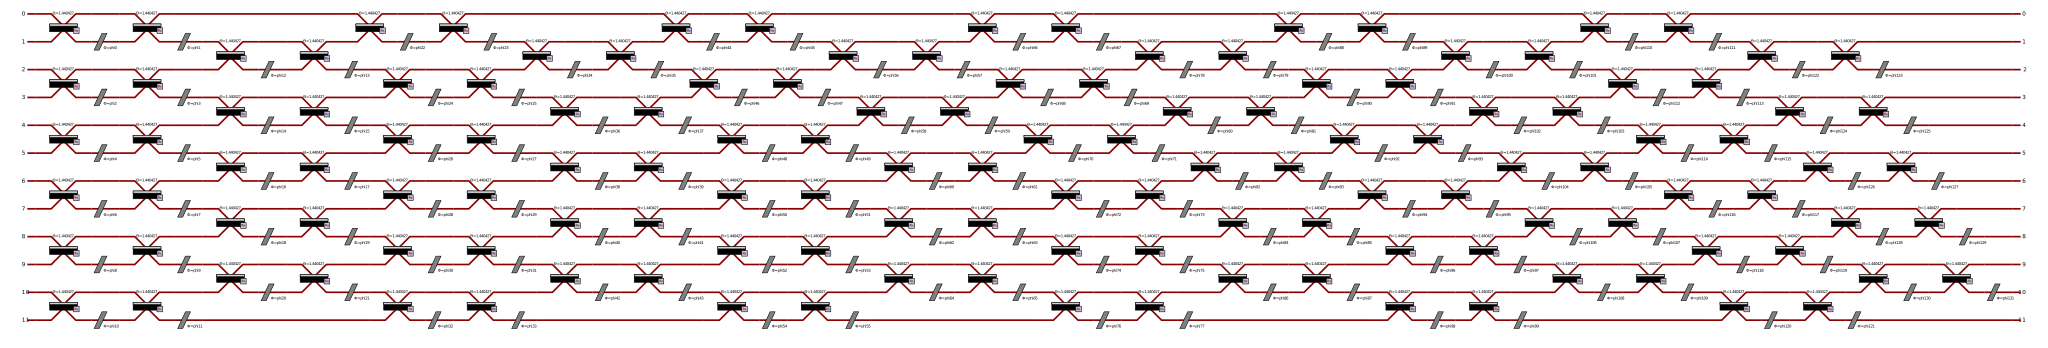

In [4]:
specs = remote_simulator.specs
pcvl.pdisplay(specs["specific_circuit"])

In [5]:
print(specs["constraints"])
print(specs["parameters"])

{'max_mode_count': 12, 'max_photon_count': 6, 'min_mode_count': 1, 'min_photon_count': 1}
{'HOM': 'indistinguishability value, using HOM model (default 1)', 'backend_name': 'name of the backend that will be used for computation (default "SLOS")', 'final_mode_number': 'number of modes of the output states. states having a photon on unused modes will be ignored. Useful when using computed circuits (default input_state.m)', 'g2': 'g2 value (default 0)', 'min_detected_photons': 'minimum number of detected photons to keep a state (default input_state.n)', 'phase_imprecision': 'imprecision on the phase shifter phases (default 0)', 'transmittance': 'probability that an emitted photon is sent to the system and is detected (default 1)'}


Now we have to specify what parameters we want to give to compute. For specific parameters, we have to use a special `set_parameter` function (or `set_parameters`).

In [6]:
remote_simulator.set_circuit(c)
remote_simulator.with_input(input_state)

remote_simulator.set_parameters({
    "HOM": .95,
    "transmittance": .1,
    "g2": .01
})
remote_simulator.min_detected_photons_filter(1)

We can now use the `Sampler` with our `RemoteProcessor`.

In [7]:
sampler = Sampler(remote_simulator)
sampler.default_job_name = "My sampling job"  # All jobs created by this sampler instance will have this custom name on the cloud

nsample = 200000
remote_job = sampler.sample_count.execute_async(nsample)

The order has now been sent to a distant computer. As it is an async computation, we can do other things locally before the results arrive. In our case, we will just wait for the end of the computation. If you go to the cloud website again, you could see the job and its completion status.

In [8]:
previous_prog = 0
with tqdm(total=1, bar_format='{desc}{percentage:3.0f}%|{bar}|') as tq:
    tq.set_description(f'Get {nsample} samples from {remote_simulator.name}')
    while not remote_job.is_complete:
        tq.update(remote_job.status.progress/100-previous_prog)
        previous_prog = remote_job.status.progress/100
        time.sleep(1)
    tq.update(1-previous_prog)
    tq.close()

print(f"Job status = {remote_job.status()}")

  0%|          |

Job status = SUCCESS


Once the previous cell has stopped, the job is finished (again, you can see its status on the website). We can now retrieve the results to do some computation. Here, the computation should be relatively fast (unless the simulator is unavailable or there are many requests on it), so we can use the job object we created before. If the computation lasted for a long time, we could have created a new job object and directly retrieved the result given the job id that is visible on the website.

In [9]:
''' # To retrieve your job using a job id
remote_processor = pcvl.RemoteProcessor("sim:ascella", token_qcloud)
async_job = remote_processor.resume_job(id)
'''

results = remote_job.get_results()
print(results['results'])

{
  |1,0>: 99022
  |0,1>: 98858
  |1,1>: 2120
}


You can run the same sampling on the corresponding QPU:

In [10]:
remote_qpu = pcvl.RemoteProcessor("qpu:ascella")
remote_qpu.set_circuit(c)
remote_qpu.with_input(input_state)
remote_qpu.min_detected_photons_filter(1)

sampler_on_qpu = Sampler(remote_qpu)

nsample = 200000
remote_job = sampler_on_qpu.sample_count
remote_job.name = "QPU sampling"  # You may also specify a name to individual jobs
remote_job.execute_async(nsample);

In [11]:
previous_prog = 0
with tqdm(total=1, bar_format='{desc}{percentage:3.0f}%|{bar}|') as tq:
    tq.set_description(f'Get {nsample} samples from {remote_qpu.name}')
    while not remote_job.is_complete:
        tq.update(remote_job.status.progress/100-previous_prog)
        previous_prog = remote_job.status.progress/100
        time.sleep(1)
    tq.update(1-previous_prog)
    tq.close()

print(f"Job status = {remote_job.status()}")

  0%|          |

Job status = SUCCESS


In [12]:
results = remote_job.get_results()
print(results['results'])

{
  |1,0>: 211538
  |0,1>: 178621
  |1,1>: 5013
}
